Source: http://www.healthdata.org/covid/data-downloads

Vaccinations of Germany: https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Daten/Impfquoten-Tab.html

Some important KPIs https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import datetime
import re



pd.set_option("display.max.rows",None)

In [2]:
path='D:/DataSets/Corona/World'

df_best_masks_hosp=pd.read_csv(path+str('/best_masks_hospitalization_all_locs.csv'),low_memory=False)
df_new_variant=pd.read_csv(path+str('/new_variant_hospitalization_all_locs.csv'),low_memory=False)
df_reference_hospitalization=pd.read_csv(path+str('/reference_hospitalization_all_locs.csv'),low_memory=False)
df_summary=pd.read_csv(path+str('/Summary_stats_all_locs.csv'),low_memory=False)
df_worse_hospitalization=pd.read_csv(path+str('/worse_hospitalization_all_locs.csv'),low_memory=False)

Here Comes some  functions to use in the report

In [3]:
list_of_country=[]
for i in df_best_masks_hosp['location_name'].unique():
    list_of_country.append(i)
#print(sorted(list_of_country))

In [4]:
def lineplot_func(data,x,y,title=None,hue=None):
    
    if data[x].dtypes=='object':
        x=pd.to_datetime(data[x])
    
    fig,ax=plt.subplots(figsize=(10,5))
    fig=sns.lineplot(data=data
                     ,x=x
                     ,y=y
                     ,estimator=sum
                     ,ci=None
                     ,hue=hue)
    plt.title(title)

In [5]:
#the .copy() is due to the SettingWithCopyWarning https://www.youtube.com/watch?v=4R4WsDJ-KVc 
df_ref_hos_ger=df_reference_hospitalization.loc[df_reference_hospitalization['location_name']=='Germany'].copy()
df_ref_hos_ger['date']=pd.to_datetime(df_ref_hos_ger['date'])
#df_ref_hos_ger.loc[df_ref_hos_ger['date']]=pd.to_datetime(df_ref_hos_ger['date'])

# Reference hospitalization

In [6]:
print(df_ref_hos_ger.shape)
df_ref_hos_ger.columns[df_ref_hos_ger.isna().any()].tolist()

(514, 73)


['mobility_data_type',
 'mobility_composite',
 'confirmed_infections_data_type',
 'confirmed_infections',
 'confirmed_infections_p100k_rate',
 'seroprev_mean',
 'seroprev_upper',
 'seroprev_lower',
 'seroprev_data_type']

<AxesSubplot:>

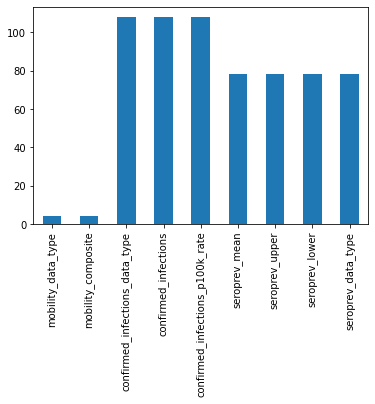

In [7]:
null_values=df_ref_hos_ger.isna().sum()
null_values=null_values[null_values>0]
null_values.plot(kind='bar')

In [8]:
print(null_values)
print(null_values.dtypes)

mobility_data_type                   4
mobility_composite                   4
confirmed_infections_data_type     108
confirmed_infections               108
confirmed_infections_p100k_rate    108
seroprev_mean                       78
seroprev_upper                      78
seroprev_lower                      78
seroprev_data_type                  78
dtype: int64
int64


There are only a few columns with NaNs. These columns pretend to two different types: mobility and confiremt infections.
The sum of NaN is among each column the same (for mobility 4 and for infections 120).
As we´ll need the infections later, we have to handle these missing quantitative values in the Dataframe.


In [9]:
quantitative=[i for i in df_ref_hos_ger.columns if df_ref_hos_ger[i].dtypes!='object']
qualitative=[i for i in df_ref_hos_ger.columns if df_ref_hos_ger[i].dtypes =='object']

In [10]:
#df_quan=df_ref_hos_ger[quantitative]
df_ref_hos_ger[quantitative].columns[df_ref_hos_ger[quantitative].isna().any()].tolist()

['mobility_composite',
 'confirmed_infections',
 'confirmed_infections_p100k_rate',
 'seroprev_mean',
 'seroprev_upper',
 'seroprev_lower']

In [11]:
df_ref_hos_ger[qualitative].columns[df_ref_hos_ger[qualitative].isna().any()].tolist()

['mobility_data_type', 'confirmed_infections_data_type', 'seroprev_data_type']

In [12]:
df_ref_hos_ger[qualitative].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 514 entries, 25367 to 25880
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   location_name                   514 non-null    object
 1   hosp_data_type                  514 non-null    object
 2   deaths_data_type                514 non-null    object
 3   mobility_data_type              510 non-null    object
 4   total_tests_data_type           514 non-null    object
 5   confirmed_infections_data_type  406 non-null    object
 6   est_infections_data_type        514 non-null    object
 7   seroprev_data_type              436 non-null    object
dtypes: object(8)
memory usage: 36.1+ KB


In [13]:
for c in qualitative:
    df_ref_hos_ger[c]=df_ref_hos_ger[c].astype('category')
       
   
    if df_ref_hos_ger[c].isnull().any():      
        df_ref_hos_ger[c] = df_ref_hos_ger[c].cat.add_categories(['MISSING'])  
        df_ref_hos_ger[c] = df_ref_hos_ger[c].fillna('MISSING')                  

In [14]:
df_ref_hos_ger[qualitative].isna().any()

location_name                     False
hosp_data_type                    False
deaths_data_type                  False
mobility_data_type                False
total_tests_data_type             False
confirmed_infections_data_type    False
est_infections_data_type          False
seroprev_data_type                False
dtype: bool

In [15]:
df_ref_hos_ger[qualitative].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 514 entries, 25367 to 25880
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   location_name                   514 non-null    category
 1   hosp_data_type                  514 non-null    category
 2   deaths_data_type                514 non-null    category
 3   mobility_data_type              514 non-null    category
 4   total_tests_data_type           514 non-null    category
 5   confirmed_infections_data_type  514 non-null    category
 6   est_infections_data_type        514 non-null    category
 7   seroprev_data_type              514 non-null    category
dtypes: category(8)
memory usage: 9.0 KB


In [16]:
for col in quantitative:
    if df_ref_hos_ger[col].isna().any():
        df_ref_hos_ger[col]=df_ref_hos_ger[col].fillna(0)


In [17]:
  df_ref_hos_ger[quantitative].columns[df_ref_hos_ger[quantitative].isna().any()].tolist()

[]

As Colums I need for the deaths:
- date
- deaths_data_type
- deaths_upper

I need also check if the deaths_data_type have any proyection into it, because I only want the observed data

In [18]:
df_ref_hos_ger['deaths_data_type'].value_counts()

observed     403
projected    111
Name: deaths_data_type, dtype: int64

As it has projected data, I will filter it more deeply to have only the observed data

In [19]:
df_ref_hos_ger_obs=df_ref_hos_ger[df_ref_hos_ger['deaths_data_type']=='observed']
print(df_ref_hos_ger_obs['deaths_data_type'].value_counts())
max_date=df_ref_hos_ger_obs['date'].max()
print(f'The lates date is: {max_date:%d %B %Y}')

observed     403
projected      0
Name: deaths_data_type, dtype: int64
The lates date is: 12 March 2021


As it the DataFrame only have observed data, we can call the function to draw a lineplot

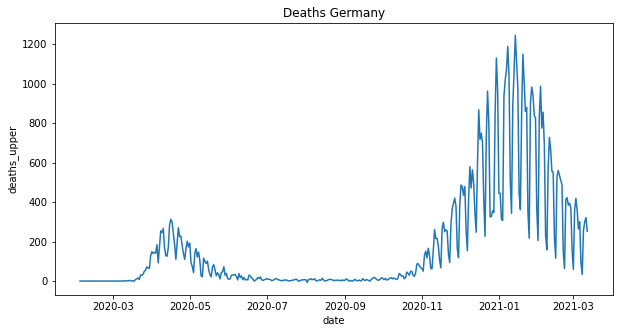

In [20]:
lineplot_func(data=df_ref_hos_ger_obs,x='date',y='deaths_upper',title='Deaths Germany')

Columns I need for the hospitalization:
- hosp_data_type
- allbed_upper -> Beds for Covid needed per day
- ICUbed_upper -> Beds for intensive care of Covid needed per day (ICU=Intensive Care Unit)
- InvVen_upper -> Upper uncertainty bound if invasive ventilation needed by day
- total_tests
- Confirmed_infections

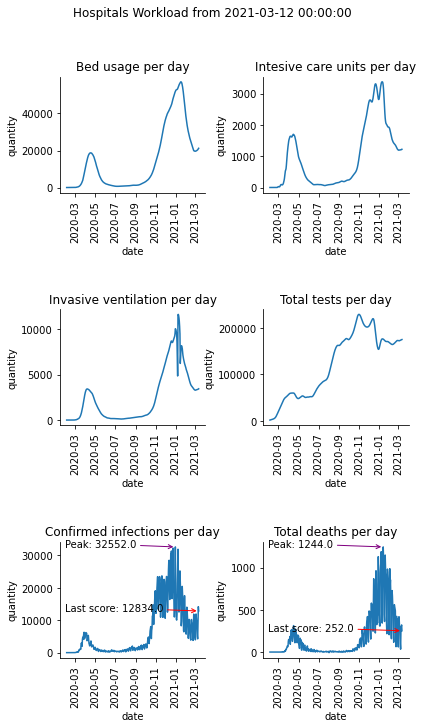

In [21]:
#Using melt for a tidy DataFrame which is more usable for FacetGrid

f=pd.melt(df_ref_hos_ger_obs
          ,value_vars=['allbed_upper'
                       ,'ICUbed_upper'
                       ,'InvVen_upper'
                       ,'total_tests'
                       ,'confirmed_infections'
                       ,'deaths_upper'
                      ]
          ,id_vars='date'
         )



#Plot the FacetGrid
g=sns.FacetGrid(f,col='variable',sharex=False,sharey=False,col_wrap=2)
g=g.map(sns.lineplot,'date','value')

#Change the title of the Subplots
axes=g.axes.flatten()
axes[0].set_title('Bed usage per day')
axes[1].set_title('Intesive care units per day')
axes[2].set_title('Invasive ventilation per day')
axes[3].set_title('Total tests per day')
axes[4].set_title('Confirmed infections per day')
axes[5].set_title('Total deaths per day')

#Make some annotation for better readibility
###ATENTION! Don´t repeat yourself. Try to do this in a loop.
#And further you can put that loop into a funcion to use it later on other data
axes[4].annotate('Last score: {}'.format(np.around(df_ref_hos_ger_obs['confirmed_infections'].iloc[-1])),
                 xy=[
                     df_ref_hos_ger_obs['date'].iloc[-1],
                     np.around(df_ref_hos_ger_obs['confirmed_infections'].iloc[-1])
                     ],
                arrowprops={'arrowstyle':'->','color':'red'},
                xytext=('2020-01-30',df_ref_hos_ger_obs['confirmed_infections'].iloc[-1])
                )

axes[5].annotate('Last score: {}'.format(np.around(df_ref_hos_ger_obs['deaths_upper'].iloc[-1])),
                 xy=[
                     df_ref_hos_ger_obs['date'].iloc[-1],
                     np.around(df_ref_hos_ger_obs['deaths_upper'].iloc[-1])
                     ],
                arrowprops={'arrowstyle':'->','color':'red'},
                xytext=('2020-01-30',df_ref_hos_ger_obs['deaths_upper'].iloc[-1])
                )


#Define the peaks of eacht plot

axes[4].annotate('Peak: {}'.format(np.around(df_ref_hos_ger_obs['confirmed_infections'].max())),
                 xy=[df_ref_hos_ger_obs['date'][df_ref_hos_ger_obs['confirmed_infections']==df_ref_hos_ger_obs['confirmed_infections'].max()],
                 np.around(df_ref_hos_ger_obs['confirmed_infections'].max())  
                 ],
                arrowprops={'arrowstyle':'->','color':'purple'},
                xytext=('2020-01-30',df_ref_hos_ger_obs['confirmed_infections'].max())
                )

axes[5].annotate('Peak: {}'.format(np.around(df_ref_hos_ger_obs['deaths_upper'].max())),
                 xy=[df_ref_hos_ger_obs['date'][df_ref_hos_ger_obs['deaths_upper']==df_ref_hos_ger_obs['deaths_upper'].max()],
                     np.around(df_ref_hos_ger_obs['deaths_upper'].max())
                     ],
                arrowprops={'arrowstyle':'->','color':'purple'},
                xytext=('2020-01-30',df_ref_hos_ger_obs['deaths_upper'].max())
                )


#Change the overall Title and also the x and y axis title on each Subplot. Adjust also the width and the high
g.fig.suptitle('Hospitals Workload from {}'.format(max(df_ref_hos_ger_obs['date'])),y=1.07)
g.set(xlabel='date',ylabel='quantity')
plt.subplots_adjust(hspace=1, wspace=0.4)


#Rotate the x-axis by 90 degree
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

To Improve: Don't repeat yourself, the x-axis on the peak annotation is worng at maximum, becuase the date on the x axis is there where the y axis is max

Number of positive & negative cases per day ----- This would have helped you to compare & find correlation between positive Diagnosed and deaths/recovered. it's called "Fatality ratio" -  It is the ratio of total dead to the total positive case (per day or week) 


"Hospitalization ratio" -It is the ratio of total hospitalized (all cases admitted to hospital) to the total positive cases. 


"Positive case ratio"- It is the ratio of total positive cases to the total number of tests (number of patients appeared for covid test every day/week) 

Date of hospitalization & recovered/discharged date - this would have helped in finding/analysing the number of days taken by a patient to recover from covid infection - questions like - which gender has speedy recovery capability ? - what age group patient has speedy recovery capability?


## Vaccanations


In [22]:
vac=pd.read_excel(path+str('/Vaccanations.xlsx'),sheet_name=3)
vac_headers=['Date','FirstVaccanations','SecoundVaccanations','TotalVaccanations']
vac.drop(vac.tail(3).index,inplace=True)
vac.columns=vac_headers

In [23]:
vac['Date']=pd.to_datetime(vac['Date'])
vac.set_index('Date',inplace=True)


In [24]:
'''
In the original Data source are NaT (like-->  \''')
To get rid of it I have to use pd.notnull(). Maby thes also works with Nans, if date is indexed?
'''
vac=vac[pd.notnull(vac.index)]

In [25]:
vac.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 81 entries, 2020-12-27 to 2021-03-17
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FirstVaccanations    81 non-null     float64
 1   SecoundVaccanations  81 non-null     float64
 2   TotalVaccanations    81 non-null     float64
dtypes: float64(3)
memory usage: 2.5 KB


In [26]:
#infections_cum=df_ref_hos_ger_obs[['date','confirmed_infections']].groupby(by=df_ref_hos_ger_obs['date']).agg('cumsum')
#infections_cum

infecctions_cum=df_ref_hos_ger_obs.set_index('date')

infecctions_cum=infecctions_cum['confirmed_infections'].cumsum()


Text(0.5, 1.0, 'Confirmed Infections vs. Vaccanations per day')

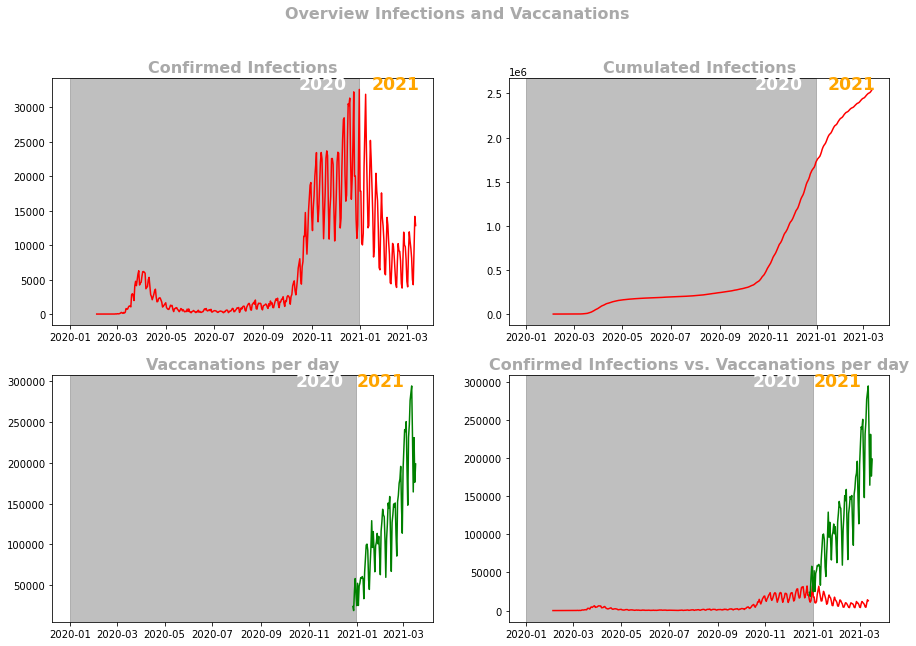

In [27]:
#create the subplots (2x2)
fig,ax=plt.subplots(2,2,figsize=(15,10))
fig.suptitle('Overview Infections and Vaccanations',fontsize=16,
            fontweight='bold',
            color='darkgrey')
#Assign subplot 1 of 4
ax1=ax[0,0]
ax1.plot(df_ref_hos_ger_obs['date'],
         df_ref_hos_ger_obs['confirmed_infections'],
         color='red'
        )

ax1.axvspan(datetime.date(2020,1,1),
            datetime.date(2020,12,31),
            color='grey',alpha=.5
           )
ax1.text(x=datetime.date(2020,10,15),
         y=df_ref_hos_ger_obs['confirmed_infections'].max(),
         s='2020',
         color='white',
         fontsize='xx-large',
         fontweight='bold'
        )
ax1.text(x=datetime.date(2021,1,15),
         y=df_ref_hos_ger_obs['confirmed_infections'].max(),
         s='2021',
         color='orange',
         fontsize='xx-large',
         fontweight='bold'
        )
ax1.set_title(label='Confirmed Infections',
              fontdict={'fontsize':16,'color':'darkgrey','fontweight':'bold'}
             )

#Assign subplot 2 of 4
ax2=ax[0,1]
ax2.plot(infecctions_cum,color='red')
ax2.axvspan(datetime.date(2020,1,1),
            datetime.date(2020,12,31),
            color='grey',
            alpha=.5
           )

ax2.text(x=datetime.date(2020,10,15),
         y=infecctions_cum.max(),
         s='2020',
         color='white',
         fontsize='xx-large',
         fontweight='bold'
        )

ax2.text(x=datetime.date(2021,1,15),
         y=infecctions_cum.max(),
         s='2021',color='orange',
         fontsize='xx-large',
         fontweight='bold')

ax2.set_title(label='Cumulated Infections',
              fontdict={'fontsize':16,'color':'darkgrey','fontweight':'bold'}
             )

#Assign subplot 3 of 4
ax3=ax[1,0]
ax3.plot(vac.index,
         vac['TotalVaccanations'],
         color='green'
        )

ax3.axvspan(datetime.date(2020,1,1),
            datetime.date(2020,12,31),
            color='grey',
            alpha=.5
           )

ax3.text(x=datetime.date(2020,10,15),
         y=vac['TotalVaccanations'].max(),
         s='2020',
         color='white',
         fontsize='xx-large',
         fontweight='bold'
        )

ax3.text(x=datetime.date(2021,1,1),
         y=vac['TotalVaccanations'].max(),
         s='2021',
         color='orange',
         fontsize='xx-large',
         fontweight='bold'
        )

ax3.set_title(label='Vaccanations per day',
              fontdict={'fontsize':16,'color':'darkgrey','fontweight':'bold'}
             )

#Assign subplot 4 of 4
ax4=ax[1,1]
ax4.plot(df_ref_hos_ger_obs['date'],
         df_ref_hos_ger_obs['confirmed_infections'],
         color='red'
        )
ax4.plot(vac.index,vac['TotalVaccanations'],
         color='green'
        )

ax4.axvspan(datetime.date(2020,1,1),
            datetime.date(2020,12,31),
            color='grey',
            alpha=.5
           )

ax4.text(x=datetime.date(2020,10,15),
         y=vac['TotalVaccanations'].max(),
         s='2020',
         color='white',
         fontsize='xx-large',
         fontweight='bold'
        )

ax4.text(x=datetime.date(2021,1,1),
         y=vac['TotalVaccanations'].max(),
         s='2021',
         color='orange',
         fontsize='xx-large',
         fontweight='bold'
        )

ax4.set_title(label='Confirmed Infections vs. Vaccanations per day',
              fontdict={'fontsize':16,'color':'darkgrey','fontweight':'bold'}
             )


#plt.xticks(rotation=90)
#for tick in ax:
 #   plt.xticks(rotation=90)



In [28]:
#ineplot_func(data=df_ref_hos_ger_obs,x='date',y='deaths_upper',title='Deaths Germany')
#df_ref_hos_ger_obs.info()

In [29]:
#Erstelle einen Scatterplot als Blasen und lass die Infizierten, toten und geimpften miteinander vergleichen
total_vac=sum(vac['TotalVaccanations'])
total_infec=sum(df_ref_hos_ger_obs['confirmed_infections'])
total_deaths=sum(df_ref_hos_ger_obs['deaths_upper'])

dic_scatter={'TotalVac':[total_vac],
             'TotalInfec':[total_infec],
             'TotalDeaths':[total_deaths]
            }

df_scatter=pd.DataFrame.from_dict(data=dic_scatter)
df_scatter
df_scatter_melt=pd.melt(frame=df_scatter,value_vars=['TotalDeaths','TotalInfec','TotalVac'])
df_scatter_melt
#sns.scatterplot(data=df_scatter,x='value')

,variable,value
0,TotalDeaths,73062.0
1,TotalInfec,2545400.0
2,TotalVac,10067955.0


In [30]:
encoded_df_scatter_melt=pd.get_dummies(data=df_scatter_melt,
                                       columns=['variable']
                                      )
encoded_df_scatter_melt

,value,variable_TotalDeaths,variable_TotalInfec,variable_TotalVac
0,73062.0,1,0,0
1,2545400.0,0,1,0
2,10067955.0,0,0,1


<AxesSubplot:ylabel='value'>

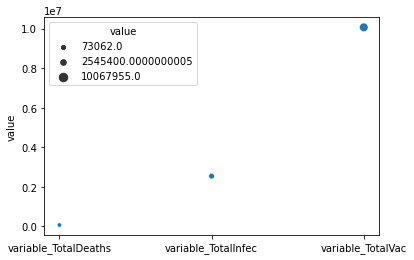

In [31]:
sns.scatterplot(data=encoded_df_scatter_melt,
                x=['variable_TotalDeaths','variable_TotalInfec','variable_TotalVac'],
               y='value',
               size='value')

In [32]:
import plotly.graph_objects as go
#import plotly.io as pio
#pio.renderers.default = "browser"

In [33]:
variables_val=[1,2,3]
df_scatter_melt['Variables']=variables_val

fig=go.Figure(data=go.Scatter(x=df_scatter_melt['Variables'],
                             y=df_scatter_melt['value'],
                             mode='markers',
                             marker=dict(size=[40,60,80],
                                        color=[0,1,2])))
#fig.show()

In [34]:
# Hole dir die Impfdaten, schaue wie viele insgesamt geimpft wurden und wie viele noch fehlen
#Rechne den durchschnittlichen täglichen Impfaufkommen aus
#Trage diesen auf die noch zu impfende Population fort, um zu errechen, wie lange wir noch bei diesem Impftempo brauchen

In [35]:
url='https://www.worldometers.info/world-population/germany-population/'
html=requests.get(url).text

In [36]:
reg=r'\d{2}\,\d{3}\,\d{3}'
text=0
soup=BeautifulSoup(html,'html.parser')
for i in soup.find_all(attrs={'class':'col-md-8 country-pop-description'}):
    text=i.find_all('li')[0].text.split('as')[0]
  
pop_germ=re.findall(reg,str(text))
pop_string=0
for i in pop_germ:
    pop_string=int(i.replace(',',''))
pop_germ=pop_string
pop_germ

83974064

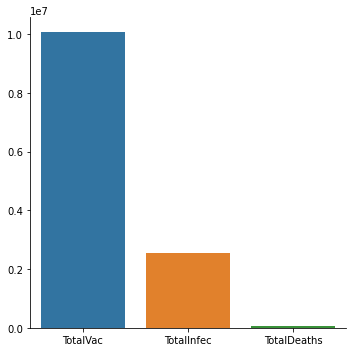

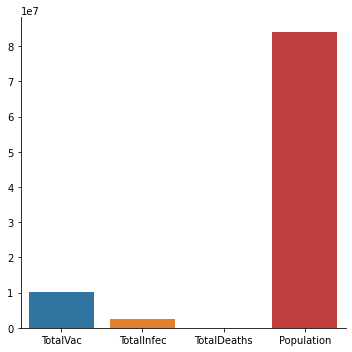

In [37]:
df_pop=df_scatter
df_pop['Population']=pop_germ
sns.catplot(kind='bar',data=df_pop[['TotalVac','TotalInfec','TotalDeaths']])
sns.catplot(kind='bar',data=df_pop[['TotalVac','TotalInfec','TotalDeaths','Population']])
f_pop=pd.melt(frame=df_pop,value_vars=['TotalVac','TotalInfec','TotalDeaths','Population'])



In [38]:
f_pop

,variable,value
0,TotalVac,10067955.0
1,TotalInfec,2545400.0
2,TotalDeaths,73062.0
3,Population,83974064.0


In [39]:
sum(vac['TotalVaccanations'])
np.mean(vac['TotalVaccanations'])


124295.74074074074

In [40]:
vac_first=sum(vac['FirstVaccanations'])
vac_sec=sum(vac['SecoundVaccanations'])
vac_first_ratio=np.around(vac_first/pop_germ*100,decimals=2)
vac_sec_ratio=np.around(vac_sec/pop_germ*100,decimals=2)
vac_first_mean=np.mean(vac['FirstVaccanations'])
vac_sec_mean=np.mean(vac['SecoundVaccanations'])

vac_first_year=np.around((pop_germ-vac_first)/vac_first_mean/360,decimals=2)
vac_sec_year=np.around((pop_germ-vac_sec)/vac_sec_mean/360,decimals=2)


In [41]:
print(
    f'The population of Germany is {pop_germ} people. At the moment are {vac_first_ratio}% of the population with their first vaccanations\n\
and {vac_sec_ratio}% with their last vaccanation. Due to the mean of first and secound vaccanations it will take {vac_first_year} years + 2 months\nto \
have the whole population with vaccanations'
)

The population of Germany is 83974064 people. At the moment are 8.3% of the population with their first vaccanations
and 3.69% with their last vaccanation. Due to the mean of first and secound vaccanations it will take 2.49 years + 2 months
to have the whole population with vaccanations


In [42]:
vac.to_csv(path_or_buf='D:\DataSets\Corona\World\To_csv\Vaccanations.csv')

In [43]:
vac.index

DatetimeIndex(['2020-12-27', '2020-12-28', '2020-12-29', '2020-12-30',
               '2020-12-31', '2021-01-01', '2021-01-02', '2021-01-03',
               '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-09', '2021-01-10', '2021-01-11',
               '2021-01-12', '2021-01-13', '2021-01-14', '2021-01-15',
               '2021-01-16', '2021-01-17', '2021-01-18', '2021-01-19',
               '2021-01-20', '2021-01-21', '2021-01-22', '2021-01-23',
               '2021-01-24', '2021-01-25', '2021-01-26', '2021-01-27',
               '2021-01-28', '2021-01-29', '2021-01-30', '2021-01-31',
               '2021-02-01', '2021-02-02', '2021-02-03', '2021-02-04',
               '2021-02-05', '2021-02-06', '2021-02-07', '2021-02-08',
               '2021-02-09', '2021-02-10', '2021-02-11', '2021-02-12',
               '2021-02-13', '2021-02-14', '2021-02-15', '2021-02-16',
               '2021-02-17', '2021-02-18', '2021-02-19', '2021-02-20',
      

In [44]:
vac_freq=vac.asfreq('D')

In [45]:
vac_weekly=vac_freq.resample('W').mean().round()
vac_monthly=vac_freq.resample('M').mean().round()
vac_monthly


,FirstVaccanations,SecoundVaccanations,TotalVaccanations
Date,,,
2020-12-31,36344.0,0.0,36344.0
2021-01-31,57394.0,18685.0,76079.0
2021-02-28,77244.0,55300.0,132543.0
2021-03-31,167477.0,57027.0,224504.0


In [46]:
vac

,FirstVaccanations,SecoundVaccanations,TotalVaccanations
Date,,,
2020-12-27,23716.0,0.0,23716.0
2020-12-28,18740.0,0.0,18740.0
2020-12-29,42648.0,0.0,42648.0
2020-12-30,58001.0,0.0,58001.0
2020-12-31,38616.0,0.0,38616.0
2021-01-01,24749.0,0.0,24749.0
2021-01-02,52180.0,0.0,52180.0
2021-01-03,24986.0,0.0,24986.0
2021-01-04,48709.0,0.0,48709.0
